# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


### Nakopírování dat

Drop Country protože v rfm diagramu nás nezajímá a případně se dá spojit a také Subtotal, protože prvně pracuji s datem

In [4]:
rfm = df.drop(['Country', 'Subtotal'], axis=1)
rfm

,Customer ID,Date
0,34,6/21/2007
1,38,6/27/2007
2,47,7/2/2007
3,61,7/14/2007
4,78,7/21/2007
...,...,...
22403,15356,12/18/2015
22404,15357,12/18/2015
22405,15358,12/18/2015
22406,15359,12/19/2015


### Recency

Protože python 3 nemá přepínač na data, která jsou v datasetu, musel jsem pro všechny dny i měsíce které nemají 2 cifry prependnout 0. Pak bylo seřazeno dle data (až po konverzi na datetime, protože sort na stringu v tomhle tvaru není dobrý nápad) a předěláno na recency. Bylo přeškálováno na logaritmus, protože rozdíly jsou obrovské (3000 dní max, a dat je jen 12000)

In [5]:
def prependZeroes(date):
    tmp = []
    for val in date.split('/'):
        if len(val) == 1:
            tmp.append(val.zfill(1+len(val)))
            # according to google python coding standards its not good practise to use +=
        else:
            tmp.append(val)
    return '/'.join(tmp)
import math
rfm['Date'] = df['Date'].apply(prependZeroes)
rfm['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
rfm = rfm.sort_values(by=['Date']).drop_duplicates(subset='Customer ID', keep='last')
last_buy = rfm['Date'].iloc[-1]
rfm['Recency'] = rfm['Date'].apply(lambda x: math.log(int((last_buy - x).days + 1)))
rfm.drop(('Date'), axis=1, inplace=True)
rfm

,Customer ID,Recency
0,34,8.040447
1,38,8.038512
2,47,8.036897
3,61,8.033009
4,78,8.030735
...,...,...
22402,14467,0.693147
22403,15356,0.693147
22405,15358,0.693147
22406,15359,0.000000


### Frequency
Jednoduchý groupby na Customer ID a spočtení počtu dat co obsahuje dané ID. Zde není potřeba škálovat, protože maximum je 45

In [6]:
tmp = df.groupby('Customer ID').count()['Date']
try:
    rfm.drop(('Frequency'), axis=1, inplace=True)
    # so the cell is rerunable
except:
    pass
rfm = rfm.join(tmp, on='Customer ID')
rfm.rename(columns={'Date': 'Frequency'}, inplace=True)

### Monetary
Groupby na Customer ID a suma. Protože subtotal je jediný 'sčítatelný' sloupec, tak vypadne jako jediný, jinak by bylo potřeba ještě měnit. Maximum bylo kolem 21000, takže bylo opět nutné přeškálovat data. Opět použit přirozený logaritmus

In [7]:
tmp = df.groupby('Customer ID').sum()
tmp['Subtotal'] = tmp['Subtotal'].apply(math.log)
tmp.rename(columns={'Subtotal':'Monetary'}, inplace=True)
try:
    rfm.drop(('Monetary'), axis=1, inplace=True)
    # so the cell is rerunable
except:
    pass
rfm = rfm.join(tmp, on='Customer ID')

### Algoritmus KMeans - superstar
Vidíme že jsme našli jeden cluster který má kolem 800 zákazníků, kteří mají medián monetary kolem $e^6$ jednotek, obsahuje i maximum monetary, medián frekvence je 9, což je v datech velmi vzácné a medián recency mají $e^6$. Takže tito zákazníci jsou určitě superstar zákazníci. Ti zbylí by se dali ještě více klasifikovat, kdybychom použili více clusterů. Což je v další buňce

Buňka byla upravena tak, aby zobrazovala pouze jeden cluster se superstar zákazníky. Pokud chcete vidět všechny odkomentujte if

,Recency,Frequency,Monetary,Cluster
count,721.000000,721.000000,721.000000,721.0
mean,5.592766,8.210818,6.519053,1.0
std,1.487073,4.322736,0.802873,0.0
min,0.693147,4.000000,4.233817,1.0
50%,6.021023,7.000000,6.491937,1.0
max,7.732808,45.000000,9.970790,1.0


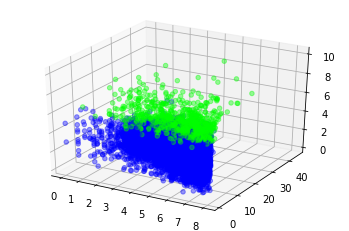

In [8]:
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)
try:
    kmeans.fit(rfm.drop(['Customer ID', 'Cluster'], axis=1))
except:
    kmeans.fit(rfm.drop(['Customer ID'], axis=1))
rfm['Cluster'] = kmeans.labels_
for i in range(n_clusters):
    if rfm[rfm['Cluster']==i].count()['Cluster'] < 1000:
        display(rfm[rfm['Cluster']==i].drop(('Customer ID'), axis=1).describe(percentiles=[.5]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='black', s=100)
plt.show()

### Algoritmus KMeans - nezajímaví zákazníci
Nezajímaví zákazníci se začali nějak více separovat až při 3 clusterech, ale při 4 je tato separace asi největší. Vidíme přes 9000 zákazníků, kteří mají maximum frekvence 3, minimum recency $e^5$ a průměrně utraceno $e^4$. To musí být naši nezajímaví!
Taktéž s vyšším počtem clusterů klesá počet vyvolených na superzákazníky. Takže pokud bychom chtěli udělat speciální VIP program pro x lidí, jednoduše bychom mohli zvyšovat počet clusterů do té doby, než to číslo nebude blízké případně menší (blízké, protože v bysnysu se dá vyjednávat... :) )

Buňka byla upravena tak, aby zobrazovala pouze jeden cluster s nezajímavými zákazníky. Pokud chcete vidět všechny odkomentujte if

,Recency,Frequency,Monetary,Cluster
count,9101.000000,9101.000000,9101.000000,9101.0
mean,7.110607,1.157675,3.912491,0.0
std,0.513434,0.386124,0.946557,0.0
min,5.468060,1.000000,0.165514,0.0
50%,7.202661,1.000000,3.924544,0.0
max,8.040447,3.000000,7.009770,0.0


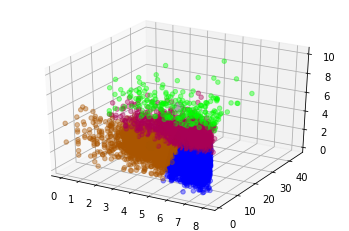

In [9]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)
try:
    kmeans.fit(rfm.drop(['Customer ID', 'Cluster'], axis=1))
except:
    kmeans.fit(rfm.drop(['Customer ID'], axis=1))
rfm['Cluster'] = kmeans.labels_
for i in range(n_clusters):
    if rfm[rfm['Cluster']==i].count()['Cluster'] > 8000:
        display(rfm[rfm['Cluster']==i].drop(('Customer ID'), axis=1).describe(percentiles=[.5]))

        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='black', s=100)
plt.show()

## BONUS 2

In [10]:
rfm_bonus = df.drop(['Country', 'Subtotal'], axis=1)
#rfm_bonus

### Recency bonus
V lambda funkci oproti globálnímu zacílení máme malou změnu. Je tam také odchylka, protože python neumí pořádně v datetime objectu pracovat s měsíci (což chápu, protože to je netriviální). 

In [11]:
rfm_bonus['Date'] = df['Date'].apply(prependZeroes)
rfm_bonus['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
rfm_bonus = rfm_bonus.sort_values(by=['Date']).drop_duplicates(subset='Customer ID', keep='last')
last_buy = rfm_bonus['Date'].iloc[-1]
rfm_bonus['Recency'] = rfm_bonus['Date'].apply(lambda x: max(int((last_buy - x).days/30), 1))
rfm_bonus.drop(('Date'), axis=1, inplace=True)
# rfm_bonus

### Frequency bonus
.last umí posledních 12 měsíců na timedate objectu, takže jediné co je nutné je dostat to do indexu, pak už je to hračka

In [20]:
tmp = df.drop(['Country', 'Subtotal'], axis=1)
tmp['Date'] = tmp['Date'].apply(prependZeroes)
tmp['Date'] = tmp['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
tmp = tmp.rename(index={k:v for k,v in zip(list(tmp.index), tmp['Date'])}).last('12M').groupby('Customer ID').count()['Date']
try:
    rfm_bonus.drop(('Frequency'), axis=1, inplace=True) 
    # so the cell is rerunable
except:
    pass
rfm_bonus = rfm_bonus.join(tmp, on='Customer ID')
rfm_bonus.rename(columns={'Date': 'Frequency'}, inplace=True)
rfm_bonus.fillna(1, inplace=True) # pokud tam nebylo tak max z 0 a 1 je 1, takze muzu pouzit fillna
rfm_bonus.drop(('Customer ID'), axis=1).describe()

,Recency,Frequency
count,12829.000000,12829.000000
mean,36.298776,1.088627
std,24.190337,0.524592
min,1.000000,1.000000
25%,15.000000,1.000000
50%,35.000000,1.000000
75%,56.000000,1.000000
max,103.000000,18.000000


### Monetary bonus
Triviální, vezmeme jen maximum

In [27]:
tmp = df.groupby('Customer ID').max()['Subtotal']
tmp = tmp.apply(math.sqrt)
try:
    rfm_bonus.drop(('Monetary'), axis=1, inplace=True)
    # so the cell is rerunable
except:
    pass
rfm_bonus = rfm_bonus.join(tmp, on='Customer ID')
rfm_bonus.rename(columns={'Subtotal':'Monetary'}, inplace=True)

### KMeans bonus
Zákazníkům ubylo počet dat. Je nyní těžší segregovat více nakupující od méně, data nám jakoby proužkovatí. Dokázali jsme najít zákazníky, kteří mají relativně vysoké monetary, nižší recency a vysoká frequency. Lokální zacílení tedy ztíží algoritmu kmeans schopnost třídit zákazníky. Na druhou stranu to může vyfiltrovat bubáky, které v globálních datech straší (viz jeden nákup za 21000)

Tento přístup se může hodit při určitém zacílení na nedávnou dobu. Nicméně tato data jsou spíše špatná, hodil by se spíš nějaká samoobsluha a né nějaký obchod s elektronikou, případně něčím specifickým, což je případ těchto dat. Zde je lepší použít právě globálnější zacílení, kvůli né až tak velké pravidelnosti nákupů

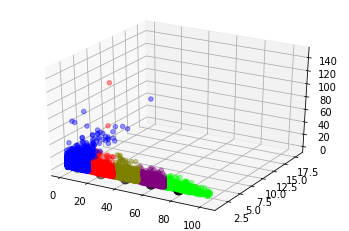

,Recency,Frequency,Cluster,Monetary
count,3504.000000,3504.000000,3504.0,3504.000000
mean,7.371861,1.324486,0.0,9.399540
std,4.992900,0.964997,0.0,5.440239
min,1.000000,1.000000,0.0,1.577973
50%,7.000000,1.000000,0.0,8.192069
max,17.000000,18.000000,0.0,88.951279


,Recency,Frequency,Cluster,Monetary
count,2469.000000,2469.0,2469.0,2469.000000
mean,61.682463,1.0,1.0,7.654557
std,5.109381,0.0,0.0,3.606260
min,53.000000,1.0,1.0,1.296148
50%,62.000000,1.0,1.0,6.906519
max,71.000000,1.0,1.0,28.195567


,Recency,Frequency,Cluster,Monetary
count,2849.000000,2849.0,2849.0,2849.000000
mean,25.676378,1.0,2.0,8.808481
std,5.079067,0.0,0.0,5.386123
min,17.000000,1.0,2.0,1.086278
50%,26.000000,1.0,2.0,7.811530
max,35.000000,1.0,2.0,144.917390


,Recency,Frequency,Cluster,Monetary
count,2933.000000,2933.0,2933.0,2933.000000
mean,43.396863,1.0,3.0,8.392182
std,5.147883,0.0,0.0,4.178622
min,35.000000,1.0,3.0,1.280625
50%,43.000000,1.0,3.0,7.561746
max,53.000000,1.0,3.0,37.982891


,Recency,Frequency,Cluster,Monetary
count,1074.000000,1074.0,1074.0,1074.000000
mean,81.114525,1.0,4.0,7.220709
std,7.124568,0.0,0.0,3.263566
min,72.000000,1.0,4.0,1.341641
50%,80.000000,1.0,4.0,6.631365
max,103.000000,1.0,4.0,22.746428


In [28]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)
kmeans.fit(rfm_bonus.drop(('Customer ID'), axis=1))
try:
    rfm_bonus['Cluster'] = kmeans.predict(rfm_bonus.drop(['Customer ID', 'Cluster'], axis=1))
except:
    rfm_bonus['Cluster'] = kmeans.predict(rfm_bonus.drop(['Customer ID'], axis=1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_bonus['Recency'], rfm_bonus['Frequency'], rfm_bonus['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='black', s=100)
plt.show()
for i in range(n_clusters):
    #if rfm[rfm['Cluster']==i].count()['Cluster'] > 8000:
    display(rfm_bonus[rfm_bonus['Cluster']==i].drop(('Customer ID'), axis=1).describe(percentiles=[.5]))
